<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [2]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

<h3>Get the data and copy it to S3</h3>

In [ ]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://udacitysolution/ --recursive

<h3>Set up parameters, estimator, and tuner</h3>

In [3]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [9]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

NameError: name 'role' is not defined

<h3>Fit the tuner</h3>

In [6]:
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-827713284860/udacity-solution/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-827713284860/udacity-solution/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-827713284860/udacity-solution/output/'
tuner.fit({"training": "s3://sagemaker-us-east-1-827713284860/udacity-solution/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [11]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230211-0903')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

UnknownServiceError: Unknown service: 'sagemaker'. Valid service names are: accessanalyzer, account, acm, acm-pca, alexaforbusiness, amp, amplify, amplifybackend, amplifyuibuilder, apigateway, apigatewaymanagementapi, apigatewayv2, appconfig, appconfigdata, appflow, appintegrations, application-autoscaling, application-insights, applicationcostprofiler, appmesh, apprunner, appstream, appsync, arc-zonal-shift, athena, auditmanager, autoscaling, autoscaling-plans, backup, backup-gateway, backupstorage, batch, billingconductor, braket, budgets, ce, chime, chime-sdk-identity, chime-sdk-media-pipelines, chime-sdk-meetings, chime-sdk-messaging, chime-sdk-voice, cleanrooms, cloud9, cloudcontrol, clouddirectory, cloudformation, cloudfront, cloudhsm, cloudhsmv2, cloudsearch, cloudsearchdomain, cloudtrail, cloudtrail-data, cloudwatch, codeartifact, codebuild, codecatalyst, codecommit, codedeploy, codeguru-reviewer, codeguruprofiler, codepipeline, codestar, codestar-connections, codestar-notifications, cognito-identity, cognito-idp, cognito-sync, comprehend, comprehendmedical, compute-optimizer, config, connect, connect-contact-lens, connectcampaigns, connectcases, connectparticipant, controltower, cur, customer-profiles, databrew, dataexchange, datapipeline, datasync, dax, detective, devicefarm, devops-guru, directconnect, discovery, dlm, dms, docdb, docdb-elastic, drs, ds, dynamodb, dynamodbstreams, ebs, ec2, ec2-instance-connect, ecr, ecr-public, ecs, efs, eks, elastic-inference, elasticache, elasticbeanstalk, elastictranscoder, elb, elbv2, emr, emr-containers, emr-serverless, es, events, evidently, finspace, finspace-data, firehose, fis, fms, forecast, forecastquery, frauddetector, fsx, gamelift, gamesparks, glacier, globalaccelerator, glue, grafana, greengrass, greengrassv2, groundstation, guardduty, health, healthlake, honeycode, iam, identitystore, imagebuilder, importexport, inspector, inspector2, iot, iot-data, iot-jobs-data, iot-roborunner, iot1click-devices, iot1click-projects, iotanalytics, iotdeviceadvisor, iotevents, iotevents-data, iotfleethub, iotfleetwise, iotsecuretunneling, iotsitewise, iotthingsgraph, iottwinmaker, iotwireless, ivs, ivschat, kafka, kafkaconnect, kendra, kendra-ranking, keyspaces, kinesis, kinesis-video-archived-media, kinesis-video-media, kinesis-video-signaling, kinesis-video-webrtc-storage, kinesisanalytics, kinesisanalyticsv2, kinesisvideo, kms, lakeformation, lambda, lex-models, lex-runtime, lexv2-models, lexv2-runtime, license-manager, license-manager-linux-subscriptions, license-manager-user-subscriptions, lightsail, location, logs, lookoutequipment, lookoutmetrics, lookoutvision, m2, machinelearning, macie, macie2, managedblockchain, marketplace-catalog, marketplace-entitlement, marketplacecommerceanalytics, mediaconnect, mediaconvert, medialive, mediapackage, mediapackage-vod, mediastore, mediastore-data, mediatailor, memorydb, meteringmarketplace, mgh, mgn, migration-hub-refactor-spaces, migrationhub-config, migrationhuborchestrator, migrationhubstrategy, mobile, mq, mturk, mwaa, neptune, network-firewall, networkmanager, nimble, oam, omics, opensearch, opensearchserverless, opsworks, opsworkscm, organizations, outposts, panorama, personalize, personalize-events, personalize-runtime, pi, pinpoint, pinpoint-email, pinpoint-sms-voice, pinpoint-sms-voice-v2, pipes, polly, pricing, privatenetworks, proton, qldb, qldb-session, ram, rbin, rds, rds-data, redshift, redshift-data, redshift-serverless, rekognition, resiliencehub, resource-explorer-2, resource-groups, resourcegroupstaggingapi, robomaker, rolesanywhere, route53, route53-recovery-cluster, route53-recovery-control-config, route53-recovery-readiness, route53domains, route53resolver, rum, s3, s3control, s3outposts, sagemaker-a2i-runtime, sagemaker-edge, sagemaker-featurestore-runtime, sagemaker-geospatial, sagemaker-metrics, sagemaker-runtime, savingsplans, scheduler, schemas, sdb, secretsmanager, securityhub, securitylake, serverlessrepo, service-quotas, servicecatalog, servicecatalog-appregistry, servicediscovery, ses, sesv2, shield, signer, simspaceweaver, sms, sms-voice, snow-device-management, snowball, sns, sqs, ssm-contacts, ssm-incidents, ssm-sap, sso, sso-admin, sso-oidc, stepfunctions, storagegateway, sts, support, support-app, swf, synthetics, textract, timestream-query, timestream-write, transcribe, transfer, translate, voice-id, waf, waf-regional, wafv2, wellarchitected, wisdom, workdocs, worklink, workmail, workmailmessageflow, workspaces, workspaces-web, xray

## Imp: If kernel dies, how to continue from a completed training job

In [4]:
# REPRENDERE DA QUI:

BetterTrainingJobName='pytorch-training-230211-0903-002-af404483'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
my_estimator.hyperparameters()
best_estimator=my_estimator
best_estimator.hyperparameters()


2023-02-11 09:42:11 Starting - Found matching resource for reuse
2023-02-11 09:42:11 Downloading - Downloading input data
2023-02-11 09:42:11 Training - Training image download completed. Training in progress.
2023-02-11 09:42:11 Uploading - Uploading generated training model
2023-02-11 09:42:11 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"64"',
 'learning_rate': '0.0014751747950583955',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2023-02-11-09-03-06-075"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-827713284860/pytorch_dog_hpo-2023-02-11-09-03-06-075/source/sourcedir.tar.gz"'}

<h3>Prepare to perform Training on Best Estimator</h3>

In [16]:
best_estimator=tuner.best_estimator()


2023-02-11 09:23:49 Starting - Preparing the instances for training
2023-02-11 09:23:49 Downloading - Downloading input data
2023-02-11 09:23:49 Training - Training image download completed. Training in progress.
2023-02-11 09:23:49 Uploading - Uploading generated training model
2023-02-11 09:23:49 Completed - Resource reused by training job: pytorch-training-230211-0903-002-af404483


In [5]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"64"',
 'learning_rate': '0.0014751747950583955',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2023-02-11-09-03-06-075"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-827713284860/pytorch_dog_hpo-2023-02-11-09-03-06-075/source/sourcedir.tar.gz"'}

In [6]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 64, 'learning_rate': '0.0014751747950583955'}

In [7]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [8]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

<h2>Creating an Estimator</h2>

In [9]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [10]:
estimator.fit({"training": "s3://sagemaker-us-east-1-827713284860/udacity-solution/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-02-11-12-00-42-741


2023-02-11 12:00:44 Starting - Starting the training job...
2023-02-11 12:01:09 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-02-11 12:02:09 Downloading - Downloading input data......
2023-02-11 12:03:09 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-11 12:03:11,339 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-11 12:03:11,342 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-02-11 12:03:11,353 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-11 12:03:11,355 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-11 12:03:11,531 sagemaker-

<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [19]:
###in this cell, create and fit an estimator using multi-instance training


<h2>Deployment</h2>

In [12]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-827713284860/dog-pytorch-2023-02-11-12-00-42-741/output/model.tar.gz


In [13]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [14]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [17]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [18]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Creating model with name: pytorch-inference-2023-02-11-13-10-12-114
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-02-11-13-10-12-631
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-02-11-13-10-12-631


------!

In [22]:
import requests
request_dict={ "url": "https://sagemaker-us-east-1-827713284860.s3.amazonaws.com/udacity-solution/test/007.American_foxhound/American_foxhound_00484.jpg" }
#request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

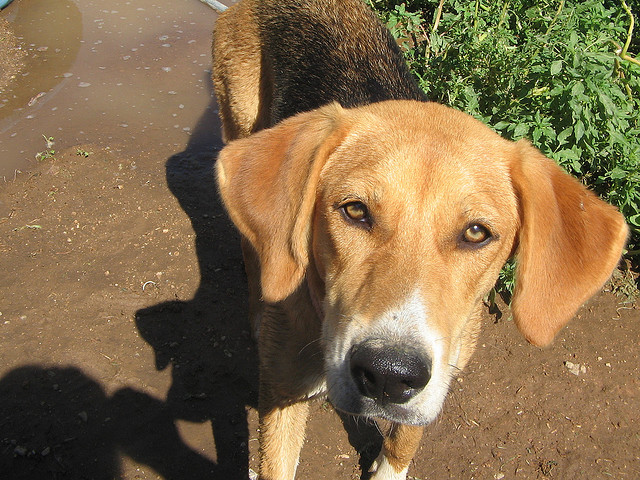

In [24]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [25]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [28]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [29]:
type(response2[0][0])

float

In [30]:
response2[0]

[-9.020395278930664,
 -4.047746658325195,
 -0.9938492178916931,
 -2.0857460498809814,
 -5.640287399291992,
 -7.09006929397583,
 2.9217910766601562,
 0.018085245043039322,
 -3.8333282470703125,
 0.05542027950286865,
 -1.6512442827224731,
 -3.329075813293457,
 -6.092785358428955,
 -0.21848666667938232,
 -0.3472774028778076,
 3.154085159301758,
 -7.659881114959717,
 -2.4851651191711426,
 -1.3775824308395386,
 -3.4876325130462646,
 -5.591823101043701,
 -5.4589667320251465,
 -7.217687606811523,
 -6.504116058349609,
 0.06486982107162476,
 -7.699436187744141,
 -0.6338642835617065,
 -0.6644068360328674,
 -4.351158142089844,
 -3.330751657485962,
 -1.0315732955932617,
 -3.8472983837127686,
 -6.836858749389648,
 -0.49399301409721375,
 -6.191007137298584,
 -7.608083248138428,
 -1.20090913772583,
 -5.441456317901611,
 0.23325860500335693,
 -0.5982828140258789,
 -2.082700729370117,
 -6.4684977531433105,
 0.08401789516210556,
 -1.7841342687606812,
 -1.7834779024124146,
 -4.5539727210998535,
 -2.76412

In [39]:
import numpy as np

np.argmax(np.array(response[0]))

15

In [42]:
#import torch
import numpy as np
np.argmax(np.array(response[0]))

15